In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K


In [11]:
dataset_path = "/content/drive/My Drive/mhealth+dataset (1)/MHEALTHDATASET"

columns = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_chest_1', 'ecg_chest_2',
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
    'magnet_ankle_x', 'magnet_ankle_y', 'magnet_ankle_z',
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
    'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z',
    'activity'
]

activity_labels = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}

def load_mhealth_data(path):
    all_data = []
    for file in sorted(os.listdir(path)):
        if file.endswith('.log'):
            df = pd.read_csv(os.path.join(path, file), delim_whitespace=True, header=None)
            df.columns = columns
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_mhealth_data(dataset_path)
scaler = StandardScaler()
df[columns[:-1]] = scaler.fit_transform(df[columns[:-1]])


In [12]:
def segment_data(data, window_size=80, step=40):
    X, y = [], []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        if len(segment['activity'].unique()) == 1:
            X.append(segment.drop('activity', axis=1).values)
            y.append(segment['activity'].iloc[0])
    return np.array(X), np.array(y)

X, y = segment_data(df)
y_encoded = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def wavenet_block(inputs, filters, kernel_size, dilation_rate):
    tanh_out = Conv1D(filters, kernel_size, padding='causal',
                      dilation_rate=dilation_rate, activation='tanh')(inputs)
    sigm_out = Conv1D(filters, kernel_size, padding='causal',
                      dilation_rate=dilation_rate, activation='sigmoid')(inputs)
    out = Multiply()([tanh_out, sigm_out])
    skip = Conv1D(filters, 1)(out)
    res = Add()([skip, inputs])
    return res, skip


In [15]:
def build_transformer_wavenet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Project input to match internal model dimension
    x = Dense(64)(inputs)

    # Transformer Block
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

    # WaveNet Blocks
    skip_connections = []
    for i in range(1, 5):
        x, skip = wavenet_block(x, filters=64, kernel_size=2, dilation_rate=2**i)
        skip_connections.append(skip)

    x = Add()(skip_connections)
    x = Activation('relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_transformer_wavenet(X.shape[1:], y_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 80, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80, 64)    │      1,536 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 64)    │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 80, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 80, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 80, 64)    │          0 │ dropout_13[0][0], │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 64)    │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 80, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 80, 128)   │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 80, 64)    │      8,256 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 80, 64)    │          0 │ conv1d_20[0][0],  │
│                     │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 80, 64)    │      8,256 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 80, 64)    │      8,256 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 80, 64)    │          0 │ conv1d_21[0][0],  │
│ (Multiply)          │                   │            │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 80, 64)    │      4,160 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 80, 64)    │          0 │ conv1d_23[0][0],  │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 80, 64)    │      8,256 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 80, 64)    │      8,256 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 80, 64)    │          0 │ conv1d_24[0][0],  │
│ (Multiply)          │                   │            │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 177,292 (692.55 KB)

 Trainable params: 177,292 (692.55 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

start = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks, verbose=1)
end = time.time()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 407ms/step - accuracy: 0.6870 - loss: 1.0852 - val_accuracy: 0.8659 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 415ms/step - accuracy: 0.8458 - loss: 0.3549 - val_accuracy: 0.8865 - val_loss: 0.2584 - learning_rate: 0.0010
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step - accuracy: 0.8673 - loss: 0.2938 - val_accuracy: 0.8901 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 388ms/step - accuracy: 0.8790 - loss: 0.2662 - val_accuracy: 0.9008 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 385ms/step - accuracy: 0.8913 - loss: 0.2415 - val_accuracy: 0.8895 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 394ms/step - accuracy: 0.8988 - loss: 0.2293 - val_accuracy: 0.9043 - val_loss: 0.2242 - learning_rate: 0.0010
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 387ms/step - accuracy: 0.9

187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step
Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.70      1.00      0.82       151
     Sitting and relaxing       0.76      0.99      0.86       140
               Lying down       0.77      1.00      0.87       150
                  Walking       0.90      0.97      0.94       157
          Climbing stairs       0.81      0.91      0.86       159
      Waist bends forward       0.81      0.85      0.83       150
Frontal elevation of arms       0.71      0.97      0.82       127
Knees bending (crouching)       0.83      0.96      0.89       149
                  Cycling       0.89      0.96      0.92       137
                  Jogging       0.88      0.99      0.93       148
                  Running       0.89      0.99      0.94       138
        Jump front & back       0.99      0.92      0.95      4374

                 accuracy                           0.93      

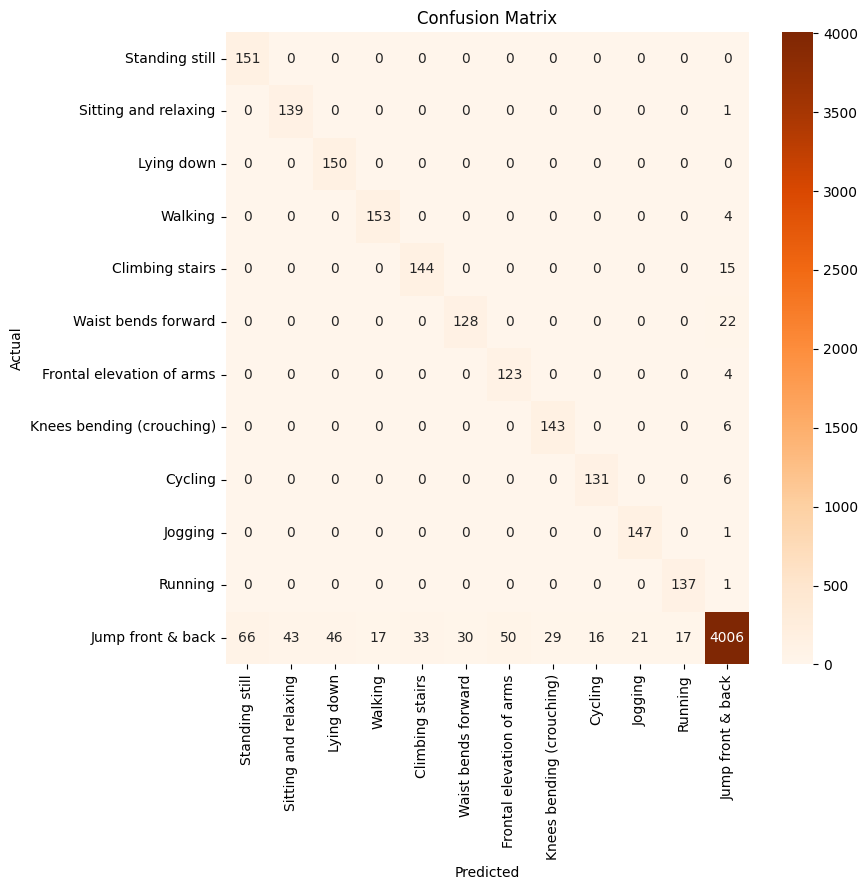

✅ Accuracy     : 92.84%
✅ Sensitivity  : 0.9594
✅ Specificity  : 0.9831
✅ MSE          : 3.9957
✅ Training Time: 1599.48 sec


In [17]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
report = classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values(), output_dict=True)
print(classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values()))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

accuracy = np.mean(y_pred_labels == y_true_labels)
mse = mean_squared_error(y_true_labels, y_pred_labels)
sensitivity = np.mean([report[label]['recall'] for label in activity_labels.values()])

specificity_list = []
for i in range(len(activity_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm.sum() - cm[:, i].sum()
    specificity_list.append(tn / fp_fn if fp_fn != 0 else 0)
specificity = np.mean(specificity_list)

print(f"✅ Accuracy     : {accuracy*100:.2f}%")
print(f"✅ Sensitivity  : {sensitivity:.4f}")
print(f"✅ Specificity  : {specificity:.4f}")
print(f"✅ MSE          : {mse:.4f}")
print(f"✅ Training Time: {end - start:.2f} sec")


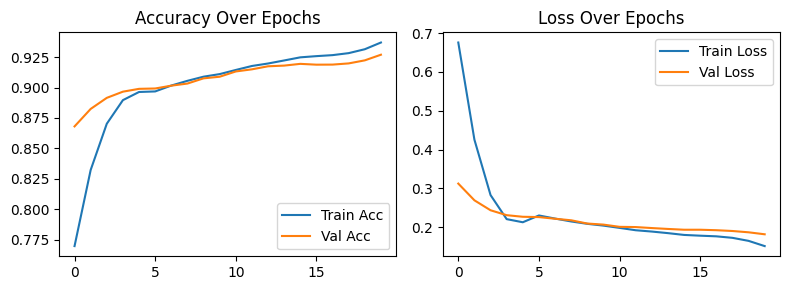

In [19]:
#Smoothed Accuracy & Loss Curves
train_acc = savgol_filter(history.history['accuracy'], 9, 3)
val_acc = savgol_filter(history.history['val_accuracy'], 9, 3)
train_loss = savgol_filter(history.history['loss'], 9, 3)
val_loss = savgol_filter(history.history['val_loss'], 9, 3)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


🎯 Train Accuracy: 94.71% | Loss: 0.1254
📊 Val Accuracy  : 92.84% | Loss: 0.1779
✅ Test Accuracy : 92.84% | Loss: 0.1779


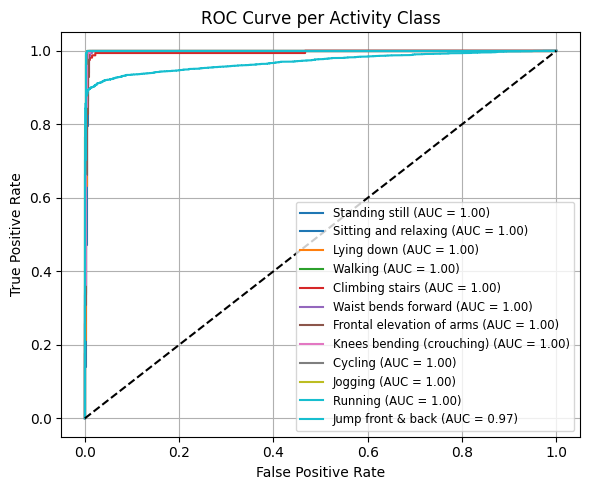

In [20]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"\n🎯 Train Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f"📊 Val Accuracy  : {val_acc*100:.2f}% | Loss: {val_loss:.4f}")
print(f"✅ Test Accuracy : {test_acc*100:.2f}% | Loss: {test_loss:.4f}")

# ROC Curve
fpr = dict(); tpr = dict(); roc_auc = dict()
n_classes = y_test.shape[1]
colors = plt.cm.get_cmap('tab10', n_classes).colors

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f"{activity_labels[i+1]} (AUC = {roc_auc[i]:.2f})",
             color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Activity Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
